In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Normalize,Resize ,CenterCrop ,Grayscale
from torch.utils.data import DataLoader

def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets
m = [0.485, 0.456, 0.406]
s = [0.229, 0.224, 0.225]
dataset = ImageFolder(r"/content/gdrive/MyDrive/Datasets/train", transform=Compose([Resize(256),
        CenterCrop(224),ToTensor(),Normalize(                      
                         mean = m,
                         std = s
                     )  ]))
print(len(dataset))
datasets = train_val_dataset(dataset)
print(len(datasets['train']))
print(len(datasets['val']))

2480
1860
620


torch.Size([20, 3, 224, 224]) torch.Size([20])


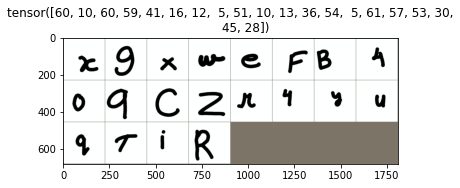

In [3]:
import cv2                
import numpy as np
import matplotlib.pyplot as plt                        
%matplotlib inline    
dataloaders = {x:DataLoader(datasets[x],20, shuffle=True, num_workers=0) for x in ['train','val']}
x,y = next(iter(dataloaders['train']))
print(x.shape, y.shape)

import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out , title = classes+1)

In [4]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding =1)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,128,3,padding =1)
        self.conv2_bn = nn.BatchNorm2d(128)
        #self.conv3 = nn.Conv2d(128,256,3,padding =1)
        #self.conv3_bn = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(56 * 56 * 128, 1000) #28*28*256
        self.fc2 = nn.Linear(1000, 62)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        #x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x= x.view(x.size(0), -1)
        x = self.dropout(x)
        x= self.fc1(x)
        x= self.fc2(x)
        return x


model_scratch = Net()
if use_cuda:
    model_scratch.cuda()

In [6]:
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.Adam(model_scratch.parameters() , lr = 0.001)

In [7]:
import time
n_epochs_stop = 5
epochs_no_improve = 0

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    
    since = time.time()
    valid_loss_min = np.Inf 
    running_corrects = 0
    
    for epoch in range(1 , n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out,target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['val']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            outputs = model(data)
            loss = criterion(outputs, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
          
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds  == target.data)

        epoch_acc = running_corrects.double() / len(datasets['val'])
    
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tEpoc Accuracy: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            epoch_acc
            ))
        
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving the model'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            epochs_no_improve = 0
            valid_loss_min = valid_loss 
        else:
            epochs_no_improve += 1
            if epochs_no_improve == n_epochs_stop:
              print('Early stopping!')
              time_elapsed = time.time() - since
              return model
              print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    return model


In [8]:
model_scratch = train(15, dataloaders, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, r'/content/gdrive/MyDrive/Saved models/model_scratch.pt')


Epoch: 1 	Training Loss: 212.796082 	Validation Loss: 52.786343 	Epoc Accuracy: 0.096774
Validation loss decreased (inf --> 52.786343). Saving the model
Epoch: 2 	Training Loss: 19.070986 	Validation Loss: 41.708168 	Epoc Accuracy: 0.272581
Validation loss decreased (52.786343 --> 41.708168). Saving the model
Epoch: 3 	Training Loss: 7.691762 	Validation Loss: 42.673405 	Epoc Accuracy: 0.450000
Epoch: 4 	Training Loss: 4.114144 	Validation Loss: 50.633774 	Epoc Accuracy: 0.625806
Epoch: 5 	Training Loss: 2.094263 	Validation Loss: 35.458817 	Epoc Accuracy: 0.885484
Validation loss decreased (41.708168 --> 35.458817). Saving the model
Epoch: 6 	Training Loss: 1.502424 	Validation Loss: 51.019962 	Epoc Accuracy: 1.069355
Epoch: 7 	Training Loss: 1.124281 	Validation Loss: 38.012405 	Epoc Accuracy: 1.308065
Epoch: 8 	Training Loss: 0.677793 	Validation Loss: 49.942638 	Epoc Accuracy: 1.511290
Epoch: 9 	Training Loss: 0.618189 	Validation Loss: 44.017059 	Epoc Accuracy: 1.717742
Epoch: 10 

In [9]:
model_scratch = train(5, dataloaders, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, r'/content/gdrive/MyDrive/Saved models/model_scratch.pt')

Epoch: 1 	Training Loss: 0.686277 	Validation Loss: 40.811626 	Epoc Accuracy: 0.261290
Validation loss decreased (inf --> 40.811626). Saving the model
Epoch: 2 	Training Loss: 0.616232 	Validation Loss: 39.948078 	Epoc Accuracy: 0.482258
Validation loss decreased (40.811626 --> 39.948078). Saving the model
Epoch: 3 	Training Loss: 0.488009 	Validation Loss: 42.298672 	Epoc Accuracy: 0.714516
Epoch: 4 	Training Loss: 0.590777 	Validation Loss: 46.030693 	Epoc Accuracy: 0.914516
Epoch: 5 	Training Loss: 0.539738 	Validation Loss: 49.421143 	Epoc Accuracy: 1.098387
Training complete in 4m 57s


#time taken = 16 minutes